# 1. Импорт библиотек

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

# 2.  Генерация и проверка начального приближения

## 2.1 Код

Функция Розенбрёка

> `x` — вектор [x, y]

In [150]:
def rosenbrock(x, y):
    return 100.0 * (y - x**2)**2 + (1.0 - x)**2

Функция градиента


In [151]:
def rosen_grad(x, y):
    dx = -400.0 * x * (y - x**2) - 2.0 * (1.0 - x)
    dy =  200.0 * (y - x**2)
    return np.array([dx, dy])

Гессиан функции Розенбрёка — матрица вторых производных

In [152]:
def rosen_hess(x, y):

    # Вторая производная по x
    dxx = 1200.0 * x**2 - 400.0 * y + 2.0

    # Смешанная производная
    dxy = -400.0 * x

    # Вторая производная по y
    dyy = 200.0

    # Возвращаем симметричную матрицу 2×2 — Гессиан
    return np.array([[dxx, dxy], [dxy, dyy]])

Функция золотого сечения для одномерной минимизации


In [153]:
def golden_section_search(phi, a = 0, b = 0.1, tol = 1e-5, max_iter = 1000):

    # Вычисляем коэффициент золотого сечения (примерно 1.618)
    gr = (np.sqrt(5) + 1) / 2

    # Обратное значение сечения
    inv_gr = 1 / gr

    # Вычисляем внутренние точки c и d внутри интервала [a, b]
    c = b - inv_gr * (b - a)
    d = a + inv_gr * (b - a)

    # Вычисляем значения функции в точках c и d
    fc = phi(c)
    fd = phi(d)

    # Основной цикл метода
    for _ in range(max_iter):

        # Если длина текущего интервала меньше заданной точности — выходим
        if abs(b - a) < tol:
            break

        # Если значение функции в c меньше, чем в d, то минимум находится ближе к c
        if fc < fd:

            # Сужаем интервал справа
            b, fd = d, fc

            # Текущую c переносим в d
            d = c

            # Вычисляем новую c
            c = b - inv_gr * (b - a)

            # Вычисляем значение функции в новой точке
            fc = phi(c)

        else:

            # Сужаем интервал слева
            a, fc = c, fd

            # Текущую d переносим в c
            c = d

            # Вычисляем новую d
            d = a + inv_gr * (b - a)


            # Вычисляем значение функции в новой точке
            fd = phi(d)

    # Возвращаем середину финального интервала как найденное приближение минимума
    return (a + b) / 2


Задаём seed и диапазон

In [154]:
seed = 42
rng = np.random.default_rng(seed)
low, high = -3.0, 3.0

In [155]:
# Генерируем стартовую точку
x0_vec = rng.uniform(low, high, size=2)
x0, y0 = x0_vec

# Оцениваем функцию и градиент в этой точке
f0 = rosenbrock(x0, y0)
grad0 = rosen_grad(x0, y0)
norm_grad0 = np.linalg.norm(grad0)

Выводим результат

In [156]:
print(f"Стартовая точка x0 = [{x0:.6f}, {y0:.6f}]")
print(f"f(x0) = {f0:.6f}")
print(f"grad f(x0) = {grad0}")
print(f"||grad f(x0)|| = {norm_grad0:.6f}")

Стартовая точка x0 = [1.643736, -0.366729]
f(x0) = 942.043984
grad f(x0) = [2018.87406572 -613.71967139]
||grad f(x0)|| = 2110.095810


## 2.2 Визуализация

Построение 3D-графика с начальной точкой

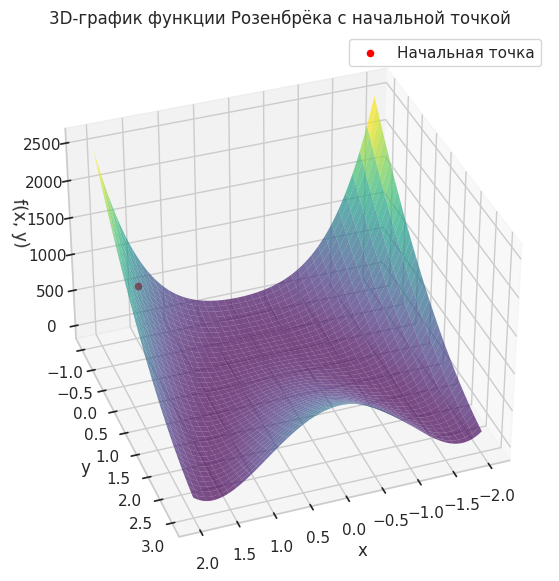

In [157]:
x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Поворот графика
ax.view_init(elev=35, azim=70)

# Поверхность
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, alpha=0.7, cmap='viridis', edgecolor='none')

# Отметка точки
z0 = f0
ax.scatter(x0, y0, z0, color='red', s = 20, label='Начальная точка')

# Оформление
ax.set_title("3D-график функции Розенбрёка с начальной точкой")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.legend()

plt.show()

# 3. Метод Heavy Ball

## 3.1 Реализация метода

In [158]:
def heavy_ball_method(x0, y0, beta=0.7, max_iter=1000, eps=1e-6):

    # Начальная инициализация координат
    x, y = x0, y0

    # Начальная скорость
    v = np.array([0.0, 0.0])

    # Сохраняем путь
    path = [(x, y)]

    # Счётчик итераций
    it = 0

    # Основной цикл
    for _ in range(max_iter):

        # Увеличиваем счётчик итераций
        it += 1

        # Вычисляем градиент функции в текущей точке
        grad = rosen_grad(x, y)

        # Определяем функцию от шага alpha вдоль направления -grad
        phi = lambda a: rosenbrock(*(np.array([x, y]) - a * grad))

        # Используем метод золотого сечения для поиска оптимального шага
        alpha = golden_section_search(phi, a = 0, b = 0.1)

        # Обновляем скорость с учётом ускорения
        v = beta * v - alpha * grad

        # Обновляем координаты с учётом текущей скорости
        x, y = x + v

        # Добавляем новую точку в путь
        path.append((x, y))

        # Проверка на сходимость по норме градиента
        if np.linalg.norm(grad) < eps:
            break

    # Финальные значения
    xf, yf = path[-1]  # последняя точка траектории
    zf = rosenbrock(xf, yf)  # значение функции в ней

    # Возвращаем:
    # - массив точек траектории
    # - финальную координату (xf, yf)
    # - значение функции в финальной точке
    # - количество итераций
    return np.array(path), (xf, yf), zf, it


In [159]:
# Запуск метода Heavy Ball
path_hb, (xf_hb, yf_hb), zf_hb, iteration_heavy_ball = heavy_ball_method(x0, y0)

In [160]:
iteration_heavy_ball

54

## 3.2 Визуализация работы метода

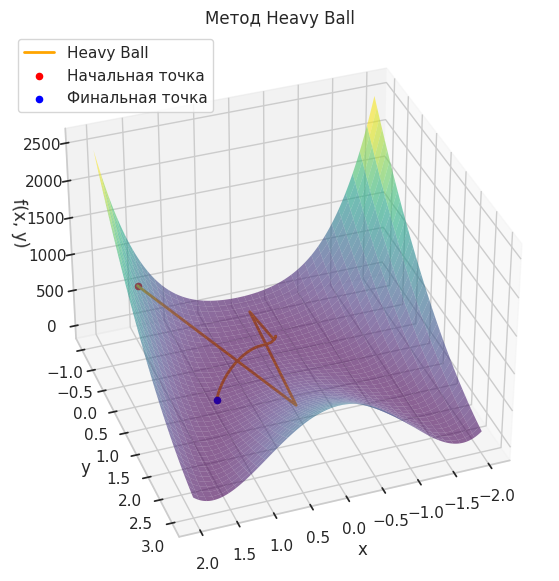

In [161]:
# Сетка для построения поверхности
x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

# Траектория метода
Z_path = rosenbrock(path_hb[:, 0], path_hb[:, 1])

# Построение графика
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Поворот графика
ax.view_init(elev=35, azim=70)

# Поверхность функции
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, alpha=0.6, cmap='viridis', edgecolor='none')

# Траектория метода
ax.plot(path_hb[:, 0], path_hb[:, 1], Z_path, color='orange', lw=2, label='Heavy Ball')

# Начальная точка
ax.scatter(path_hb[0, 0], path_hb[0, 1], Z_path[0], color='red', s=20, label='Начальная точка')

# Финальная точка
ax.scatter(path_hb[-1, 0], path_hb[-1, 1], Z_path[-1], color='blue', s=20, label='Финальная точка')

# Оформление
ax.set_title("Метод Heavy Ball")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.legend()

plt.show()


# 4. Метод Ньютона

## 4.1 Реализация метода

In [162]:
def newton_method_rosenbrock(x0, y0, eps=1e-6, max_iter=1000):
    # Начальные координаты
    x, y = x0, y0
    # Список точек траектории
    path = [(x, y)]
    # Счетчик количества итераций
    it = 0

    for _ in range(max_iter):
        it += 1
        # Вычисляем градиент и гессиан в текущей точке
        grad = rosen_grad(x, y)
        H = rosen_hess(x, y)

        try:
            # Решаем систему H·d = grad, получаем направление d
            d = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            # Если Гессиан вырожден (невозможно обратить) — останавливаем
            print("Гессиан не обратим, шаг пропущен.")
            break

        # Определяем функцию от шага alpha
        phi = lambda a: rosenbrock(*(np.array([x, y]) - a * d))

        # Используем метод золотого сечения для поиска оптимального шага
        alpha = golden_section_search(phi, a = 0, b = 0.1)

        # Делаем шаг
        x, y = np.array([x, y]) - alpha * d

        # Добавляем новую точку в путь
        path.append((x, y))

        # Проверка условия сходимости: малый градиент
        if np.linalg.norm(grad) < eps:
            break

    # Возвращаем массив всех точек пути и финальные координаты
    return np.array(path), (x, y), it

Запуск метода

In [163]:
path, (xf, yf), iteration_newton = newton_method_rosenbrock(x0, y0)

In [164]:
iteration_newton

219

## 4.2 Визуализация работы метода

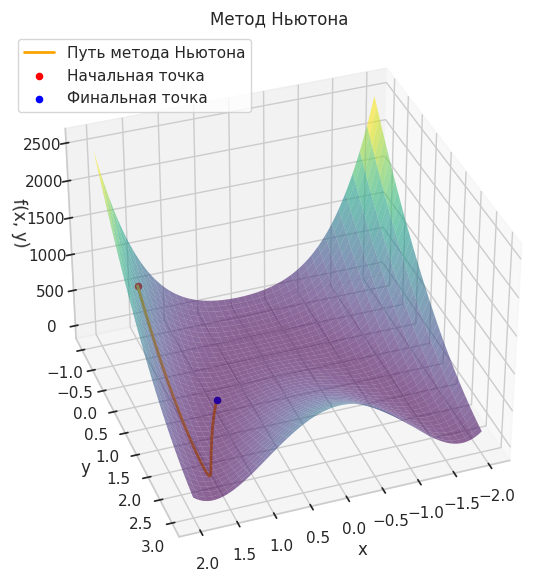

In [165]:
# Сетка для построения поверхности
x_vals = np.linspace(-2, 2, 200)
y_vals = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

# Получаем значения функции на траектории
Z_path = np.array([rosenbrock(x, y) for x, y in path])

# Построение графика
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Поворот графика
ax.view_init(elev=35, azim=70)

# Поверхность функции
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, alpha=0.6, cmap='viridis', edgecolor='none')

# Траектория метода Ньютона
ax.plot(path[:, 0], path[:, 1], Z_path, color='orange', lw=2, label='Путь метода Ньютона')

# Начальная точка
ax.scatter(path[0, 0], path[0, 1], Z_path[0], color='red', s=20, label='Начальная точка')

# Финальная точка
ax.scatter(path[-1, 0], path[-1, 1], Z_path[-1], color='blue', s=20, label='Финальная точка')

# Подписи и оформление
ax.set_title("Метод Ньютона")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.legend()

plt.show()

# 5. Метод SR-1

## 5.1 Реализация метода

In [166]:
def sr1_method_rosenbrock(x0, y0, eps=1e-6, max_iter=200000):

    # Счетчик количества итераций
    it = 0
    # Начальные координаты
    x, y = x0, y0
    # Начальное приближение для обратного Гессиана (единичная матрица)
    B_inv = np.eye(2)
    # Список точек траектории
    path = [(x, y)]

    for _ in range(max_iter):

        it += 1

        # Вычисляем градиент в текущей точке
        grad = rosen_grad(x, y)

        # Направление спуска
        d = -B_inv @ grad

        # Сохраняем текущие значения для обновления
        x_prev, y_prev = x, y
        grad_prev = grad.copy()

        # Определяем функцию от шага alpha
        phi = lambda a: rosenbrock(*(np.array([x, y]) + a * d))

        # Используем метод золотого сечения для поиска оптимального шага
        alpha = golden_section_search(phi, a = 0, b = 0.1)

        # Делаем шаг
        x, y = np.array([x, y]) + alpha * d

        # Вычисляем новый градиент
        grad_new = rosen_grad(x, y)

        # Разница градиентов
        y_k = grad_new - grad_prev

        # Разница точек
        s_k = np.array([x - x_prev, y - y_prev])

        # Вспомогательный вектор
        v_k = s_k - B_inv @ y_k

        # Обновление B_inv по формуле SR1, если условие выполняется
        if np.abs(v_k @ y_k) > eps * np.linalg.norm(v_k) * np.linalg.norm(y_k):
            B_inv += np.outer(v_k, v_k) / (v_k @ y_k)

        # Добавляем новую точку в путь
        path.append((x, y))
        # Проверка условия сходимост
        if np.linalg.norm(grad_new) < eps:
            break

    # Возвращаем массив всех точек пути и финальные координаты
    return np.array(path), (x, y), it


Запуск метода

In [167]:
path_sr1, (xf_sr1, yf_sr1), iteration_SR_1 = sr1_method_rosenbrock(x0, y0)

In [168]:
iteration_SR_1

274

## 5.2 Визуализация работы метода

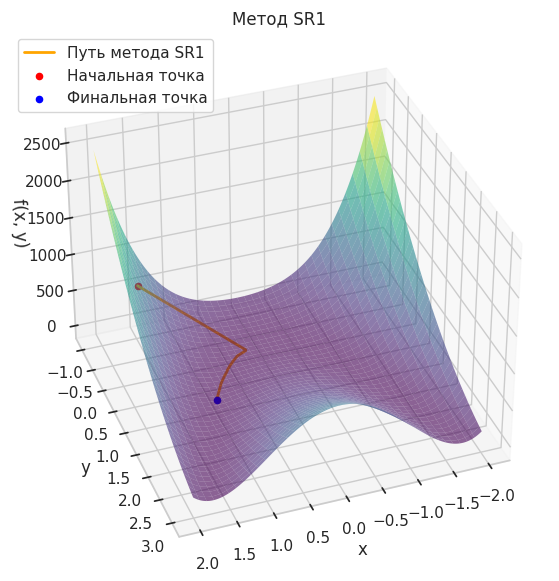

In [169]:
# Сетка для построения поверхности
x_vals = np.linspace(-2, 2, 200)
y_vals = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

# Получаем значения функции на траектории
Z_path_sr1 = np.array([rosenbrock(x, y) for x, y in path_sr1])

# Построение графика
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Поворот графика
ax.view_init(elev=35, azim=70)

# Поверхность функции
ax.plot_surface(X, Y, Z, rstride=5, cstride=5, alpha=0.6, cmap='viridis', edgecolor='none')

# Траектория метода SR1
ax.plot(path_sr1[:, 0], path_sr1[:, 1], Z_path_sr1, color='orange', lw=2, label='Путь метода SR1')

# Начальная точка
ax.scatter(path_sr1[0, 0], path_sr1[0, 1], Z_path_sr1[0], color='red', s=20, label='Начальная точка')

# Финальная точка
ax.scatter(path_sr1[-1, 0], path_sr1[-1, 1], Z_path_sr1[-1], color='blue', s=20, label='Финальная точка')

# Подписи и оформление
ax.set_title("Метод SR1")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.legend()

plt.show()

# 6. Анализ

## 6.1 Графики изменения значений функции

Функция отрисовки

In [170]:
def plot_convergence(path, name):
    values = np.array([rosenbrock(x, y) for x, y in path])
    plt.figure(figsize=(10, 5))
    plt.plot(values, lw=2)
    plt.xlabel("Итерация")
    plt.ylabel("f(x)")
    plt.title(f"Сходимость метода: {name}")
    plt.yscale("log")
    plt.grid(True)
    plt.show()
    return values[-1]

Применение функции

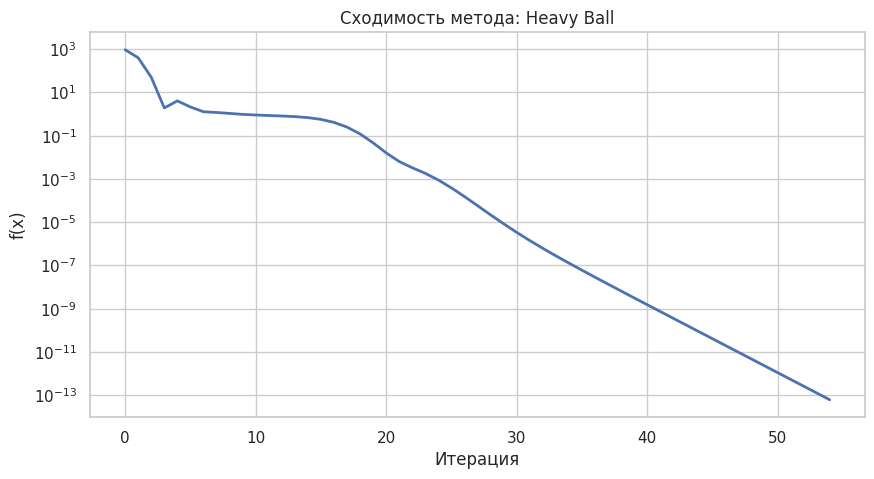

In [171]:
f_hb = plot_convergence(path_hb, "Heavy Ball")

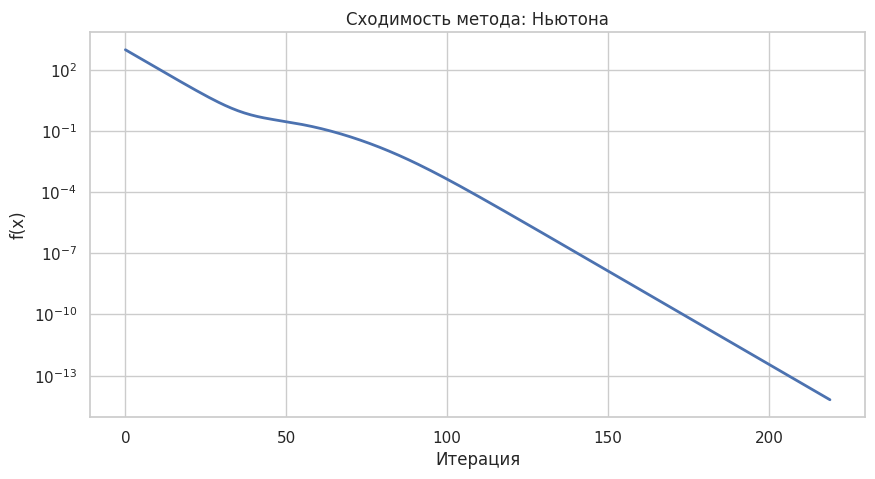

In [172]:
f_newton = plot_convergence(path, "Ньютона")

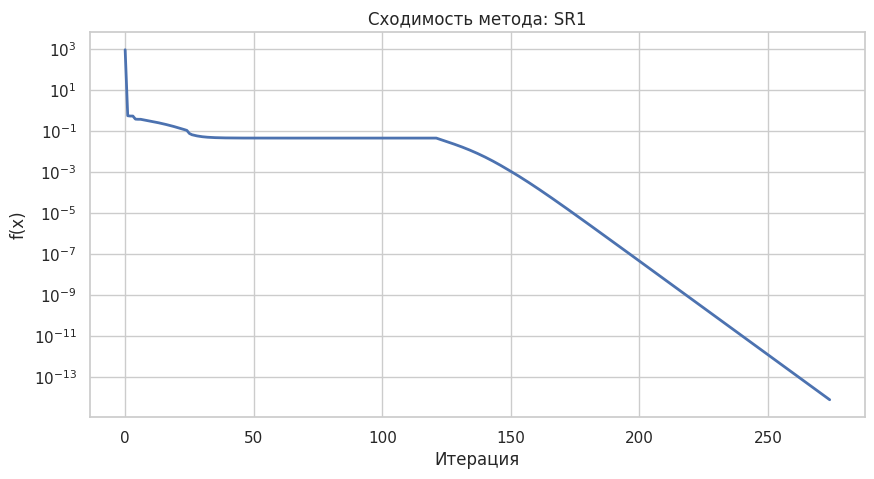

In [173]:
f_sr1 = plot_convergence(path_sr1, "SR1")

Функция отрисовки сходимости всех методов на одном графике

In [174]:
# График:
def plot_all_convergences():
    plt.figure(figsize=(10, 6))

    # Вычисляем значения функции по пути для каждого метода
    methods = [
        (path, "Ньютона"),
        (path_sr1, "SR1"),
        (path_hb, "Heavy Ball")
    ]

    for p, name in methods:
        values = [rosenbrock(x, y) for x, y in p]
        plt.plot(values, label=name)

    plt.xlabel("Итерация")
    plt.ylabel("f(x)")
    plt.yscale("log")
    plt.title("Сравнение сходимости всех методов")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

Вызов функции

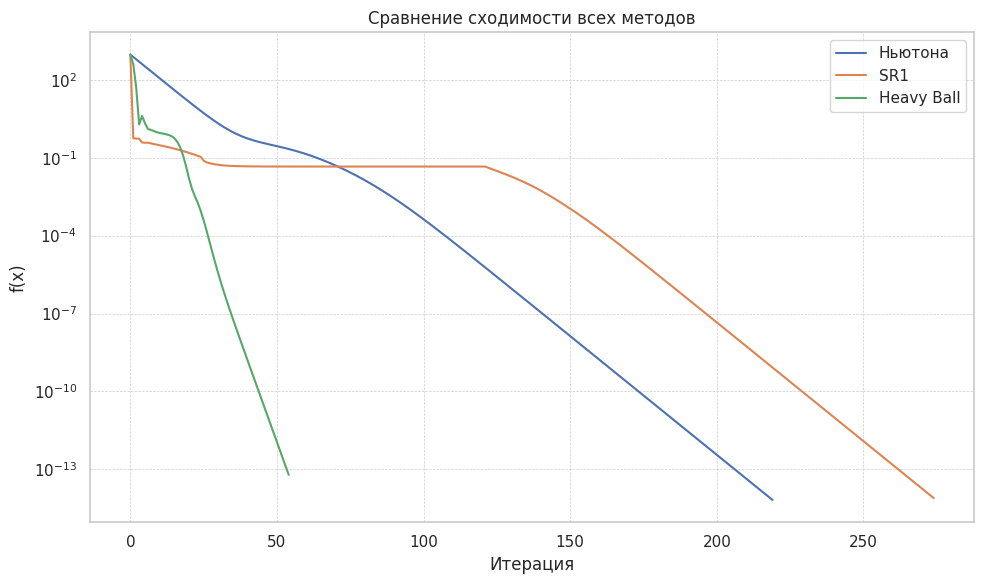

In [175]:
plot_all_convergences()

## 6.2 Таблица результатов

In [176]:
df_results = pd.DataFrame({
    "Метод": ["SR1", "Ньютона", "Heavy Ball"],
    "Итерации": [iteration_SR_1, iteration_newton, iteration_heavy_ball],
    "f(x*, y*)": [f_sr1, f_newton, f_hb],
    "Условие точности (<0.001)": [
        abs(f_sr1 - min(f_sr1, f_newton, f_hb)) < 0.001,
        abs(f_newton - min(f_sr1, f_newton, f_hb)) < 0.001,
        abs(f_hb - min(f_sr1, f_newton, f_hb)) < 0.001
    ]
})

In [179]:
df_results

,Метод,Итерации,"f(x*, y*)",Условие точности (<0.001)
0,SR1,274,7.693286e-15,True
1,Ньютона,219,6.548590e-15,True
2,Heavy Ball,54,6.129567e-14,True


## 6.3 Heatmap

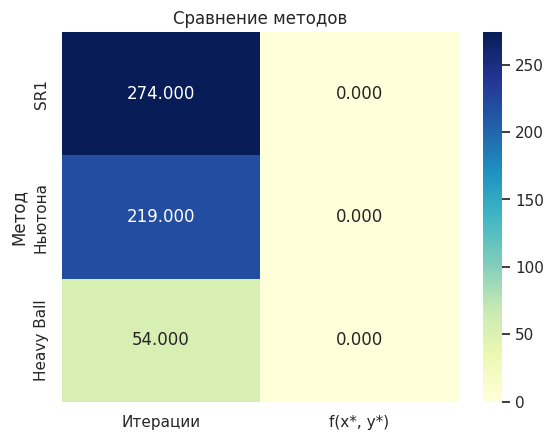

In [178]:
sns.heatmap(df_results.set_index("Метод")[["Итерации", "f(x*, y*)"]], annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Сравнение методов")
plt.show()